In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

In [5]:
X.head(3)

,track_id,track_name,track_artist,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616


In [6]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [7]:
# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [9]:
X_train

array([[ 0.63048739,  1.20401782,  0.16858069, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.47839474,  0.64774392,  1.54764467, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.12581632,  1.28663276, -1.21048328, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.58176937,  1.2370638 , -0.93467049, ...,  0.        ,
         0.        ,  0.        ],
       [-0.2129355 ,  1.04980327, -0.93467049, ...,  0.        ,
         0.        ,  0.        ],
       [-0.37194145,  1.02777263, -0.1072321 , ...,  0.        ,
         0.        ,  0.        ]])

In [10]:
y_train

0        0.66
1        0.67
2        0.70
4        0.69
5        0.67
         ... 
32824    0.20
32825    0.47
32828    0.42
32831    0.15
32832    0.27
Name: track_popularity, Length: 24255, dtype: float64

Minimum Validation Loss: 0.1984


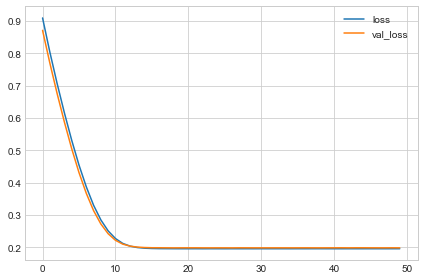

In [11]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1984


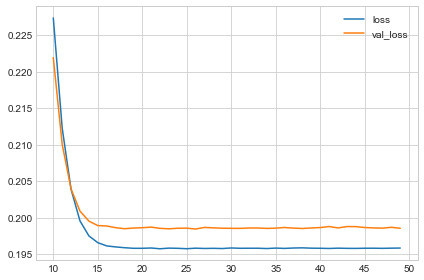

In [12]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Epoch 1/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2605 - val_loss: 0.2115
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.2017 - val_loss: 0.2036
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1963 - val_loss: 0.2013
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1932 - val_loss: 0.2022
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1914 - val_loss: 0.1996
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1895 - val_loss: 0.1993
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1884 - val_loss: 0.1992
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1878 - val_loss: 0.1989
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1868 - val_loss: 0.1996
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1855 - val_loss: 0.1980
Epoch 11/50
48/48 [

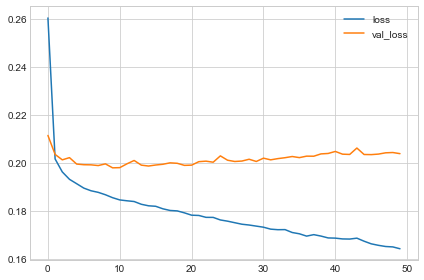

In [13]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [14]:
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/50
48/48 [==============================] - 0s 3ms/step - loss: 0.2388 - val_loss: 0.2062
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1997 - val_loss: 0.2019
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1950 - val_loss: 0.2007
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1924 - val_loss: 0.1991
Epoch 5/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1911 - val_loss: 0.1984
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1887 - val_loss: 0.1973
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1878 - val_loss: 0.1975
Epoch 8/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1866 - val_loss: 0.1971
Epoch 9/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1856 - val_loss: 0.1981
Epoch 10/50
48/48 [==============================] - 0s 2ms/step - loss: 0.1846 - val_loss: 0.1980
Epoch 11/50
48/48 [

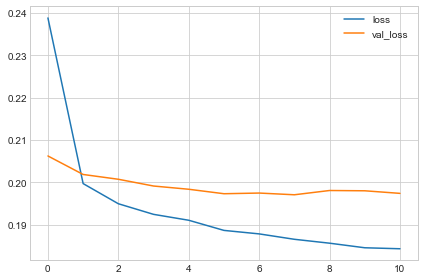

In [15]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));